In [1]:
import torch
import torch.nn as nn
import math
import copy

## 1. 位置编码（Positional Encoding）
+ **输入**：词嵌入矩阵`x`，形状为`(batch_size, seq_len, d_model)`。
+ **处理**：
    - 计算一个固定的、预定义的正余弦位置编码矩阵`PE`，形状为` (1,max_len,d_model)`。计算公式为  
    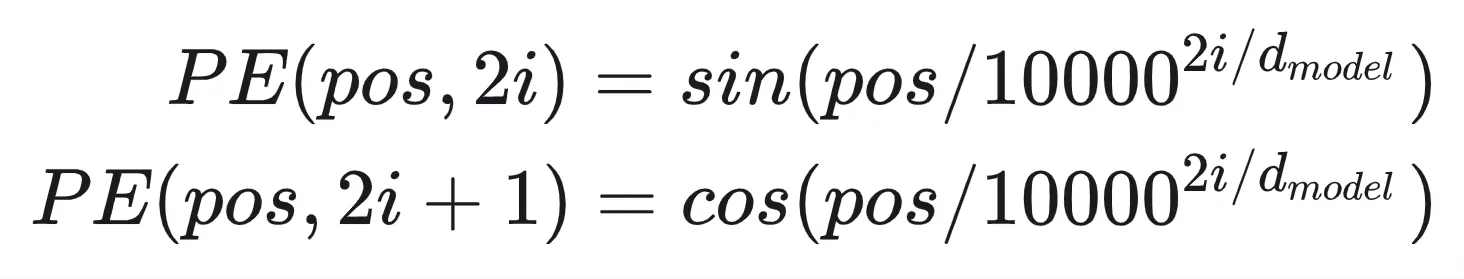
    其中包含除法变乘法的一个小trick  
    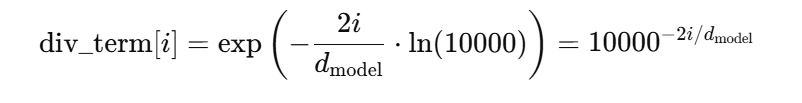![](https://cdn.nlark.com/yuque/0/2025/png/28454971/1750153358121-7ea28063-685e-4fb8-bbfe-1b0a455ef5ba.png)
    - 根据序列长度，从`PE` 中选取对应位置编码。
    - 将位置编码与输入词嵌入逐元素相加，注入位置信息。
+ **输出**：带有位置编码的词嵌入，形状不变。

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        初始化位置编码模块

        参数：
        - d_model: 每个位置的编码维度，等于Transformer中每个token的embedding维度
        - max_len: 支持的序列最大长度，默认是5000
        """
        super().__init__()
        # 创建一个全为0的张量，用于存储位置编码，形状为 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)  # 每一行对应一个位置的位置编码
        # 生成位置索引，从0到 max_len-1，形状为 (max_len, 1)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)

        # 计算不同维度对应的位置缩放因子
        # div_term是 (d_model // 2,) 大小的张量，对应偶数维度的指数项2i,其中包含除法变乘法的一个小trick
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # 将位置乘以缩放因子，然后取正弦函数赋值到pe的偶数列
        # 对于维度0,2,4,...，使用sin(position / (10000^(2i/d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)

        # 将位置乘以缩放因子，然后取余弦函数赋值到pe的奇数列
        # 对于维度1,3,5,...，使用cos(position / (10000^(2i/d_model)))
        pe[:, 1::2] = torch.cos(position * div_term)

        # 增加一维用于 batch 维度（广播用），形状变为 (1, max_len, d_model)
        # 方便后续加到输入的嵌入向量上（输入 shape 是 (batch_size, seq_len, d_model)）
        pe = pe.unsqueeze(0)

        # 将位置编码张量注册为buffer，不作为模型参数参与训练
        # 它是常量，但在模型保存和加载时会保留下来
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        前向传播：将位置编码加到输入嵌入上

        参数：
        - x: 输入的嵌入张量，形状为 (batch_size, seq_len, d_model)

        返回：
        - 加入位置编码后的张量，形状相同 (batch_size, seq_len, d_model)
        """
        # 只取对应序列长度的部分位置编码，加到输入上
        # self.pe[:, :x.size(1), :] 的 shape 是 (1, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x
        

## 2.注意力计算
+ **输入**：查询矩阵`Q`、键矩阵`K`、值矩阵`V`，形状均为`(batch_size, head_num, seq_len,d_k)` ，可选掩码`mask` 。
+ **处理**：
    - 计算注意力分数矩阵：`scores = QKT/sqrt(d_k)`，形状`(batch, head, seq, seq)`。
    - 如果有掩码，则将掩码位置对应的分数置为`-<font style="color:rgba(0, 0, 0, 0.8);">∞</font>` ，防止关注这些位置。
    - 对分数矩阵做 softmax，得到注意力权重矩阵。
    - 用权重矩阵加权值矩阵`V`，得到注意力输出。
+ **输出**：
    - 注意力输出，形状`(batch, head, seq, dk)`。
    - 注意力权重矩阵，用于可视化或分析。

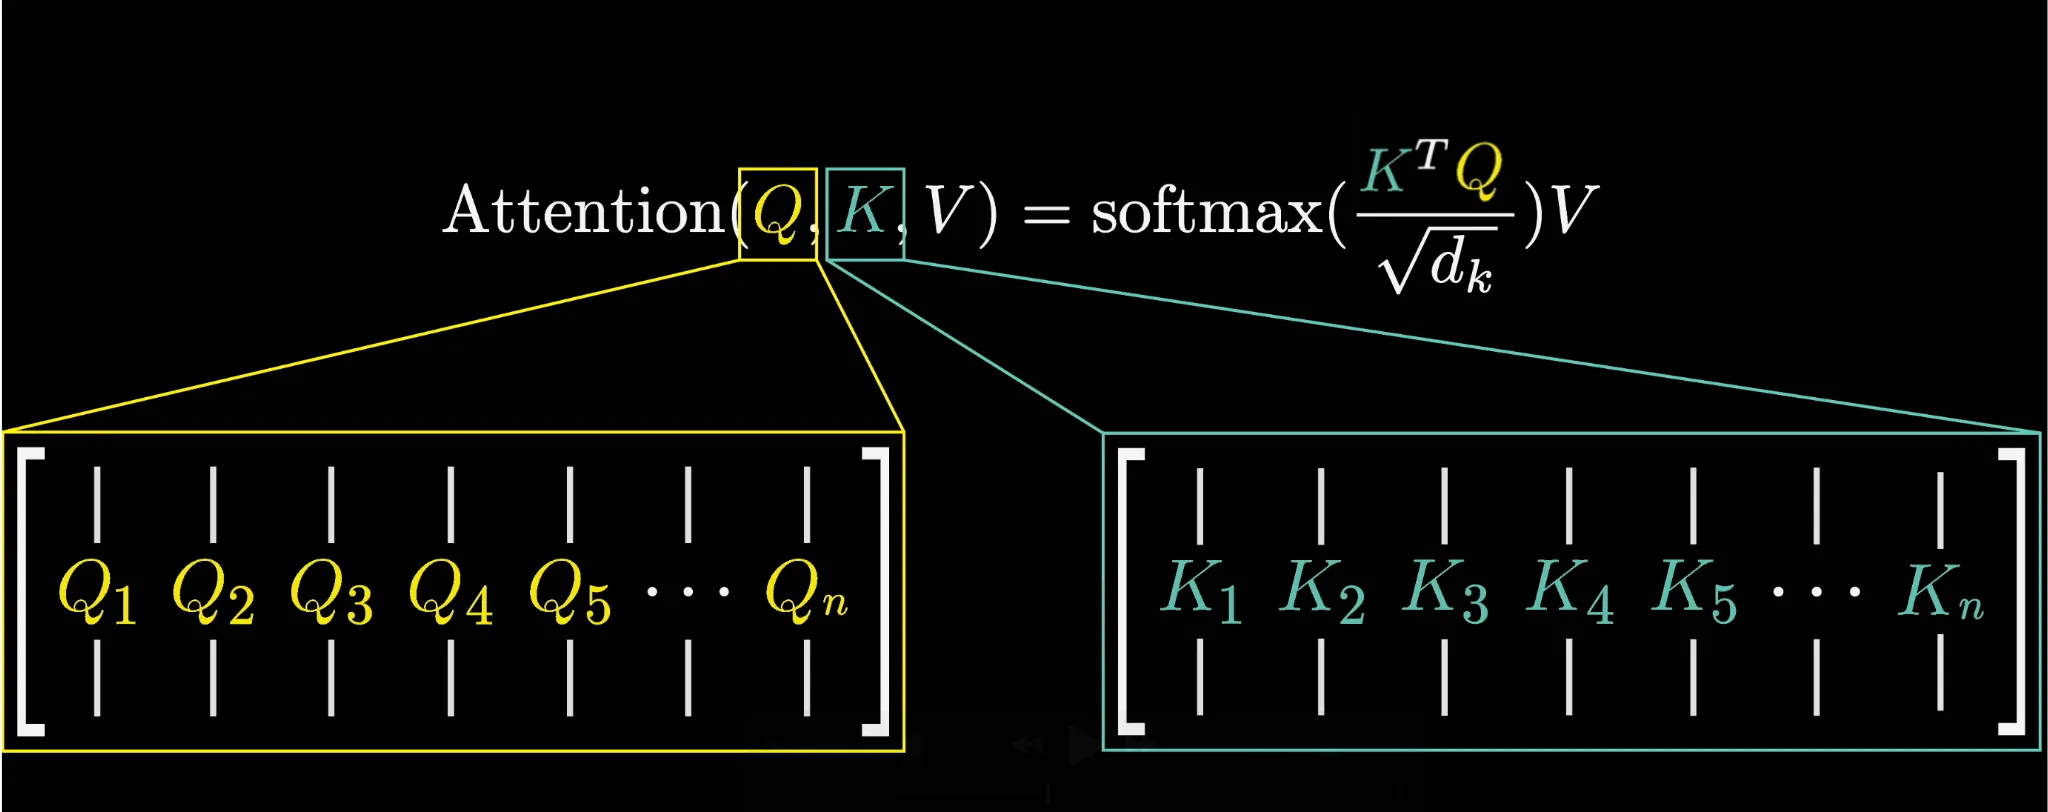

In [14]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    参数：
    - q: 查询张量 (batch_size, num_heads, seq_len, d_k)
    - k: 键张量     (batch_size, num_heads, seq_len, d_k)
    - v: 值张量     (batch_size, num_heads, seq_len, d_k)
    - mask: 掩码张量，可选。用于屏蔽某些位置（比如 padding 或未来信息）

    返回：
    - output: 注意力加权的值结果 (batch_size, num_heads, seq_len, d_k)
    - attn: 注意力权重分布 (batch_size, num_heads, seq_len, seq_len)
    """

    # 获取最后一维的大小，也就是每个头中 q/k/v 的特征维度 d_k
    d_k = q.size(-1)

    # Step 1: 点积计算注意力得分
    # Q * K^T，结果维度为 (batch_size, num_heads, seq_len, seq_len)
    # 表示第 i 个查询与第 j 个键的相似度
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    # Step 2: 掩码处理（用于屏蔽非法位置或防止信息泄露）
    if mask is not None:
        # 掩码为0的位置设为 -inf，softmax后为0（完全屏蔽）
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Step 3: 对最后一个维度做 softmax，得到注意力权重
    # 每一行代表某个 token 对所有 key 的注意力分布（加权系数）
    attn = torch.softmax(scores, dim=-1)

    # Step 4: 将注意力权重乘以值向量 V，得到最终输出
    # 类似于“从所有V中加权提取信息”
    output = torch.matmul(attn, v)

    return output, attn


## 3. 多头注意力机制（Multi-Head Attention）
+ **输入**：查询、键、值矩阵`Q,K,V`，形状`(batch,seq,d_model)` ，可选掩码。
+ **处理**：
    - 通过线性层分别映射`Q,K,V` 到多头空间，每个头的维度为` d_k = d_model/num_heads`。
    - 将映射结果 reshape 并 transpose，得到形状`(batch, head_num, seq,d_k)` 。
    - 对每个头调用缩放点积注意力，计算注意力输出。
    - 将所有头的输出拼接（concatenate）回形状 `(batch, seq, d_model)`。
    - 经过线性映射输出最终结果。
+ **输出**：多头注意力的融合输出，形状`(batch, seq, d_model)`。
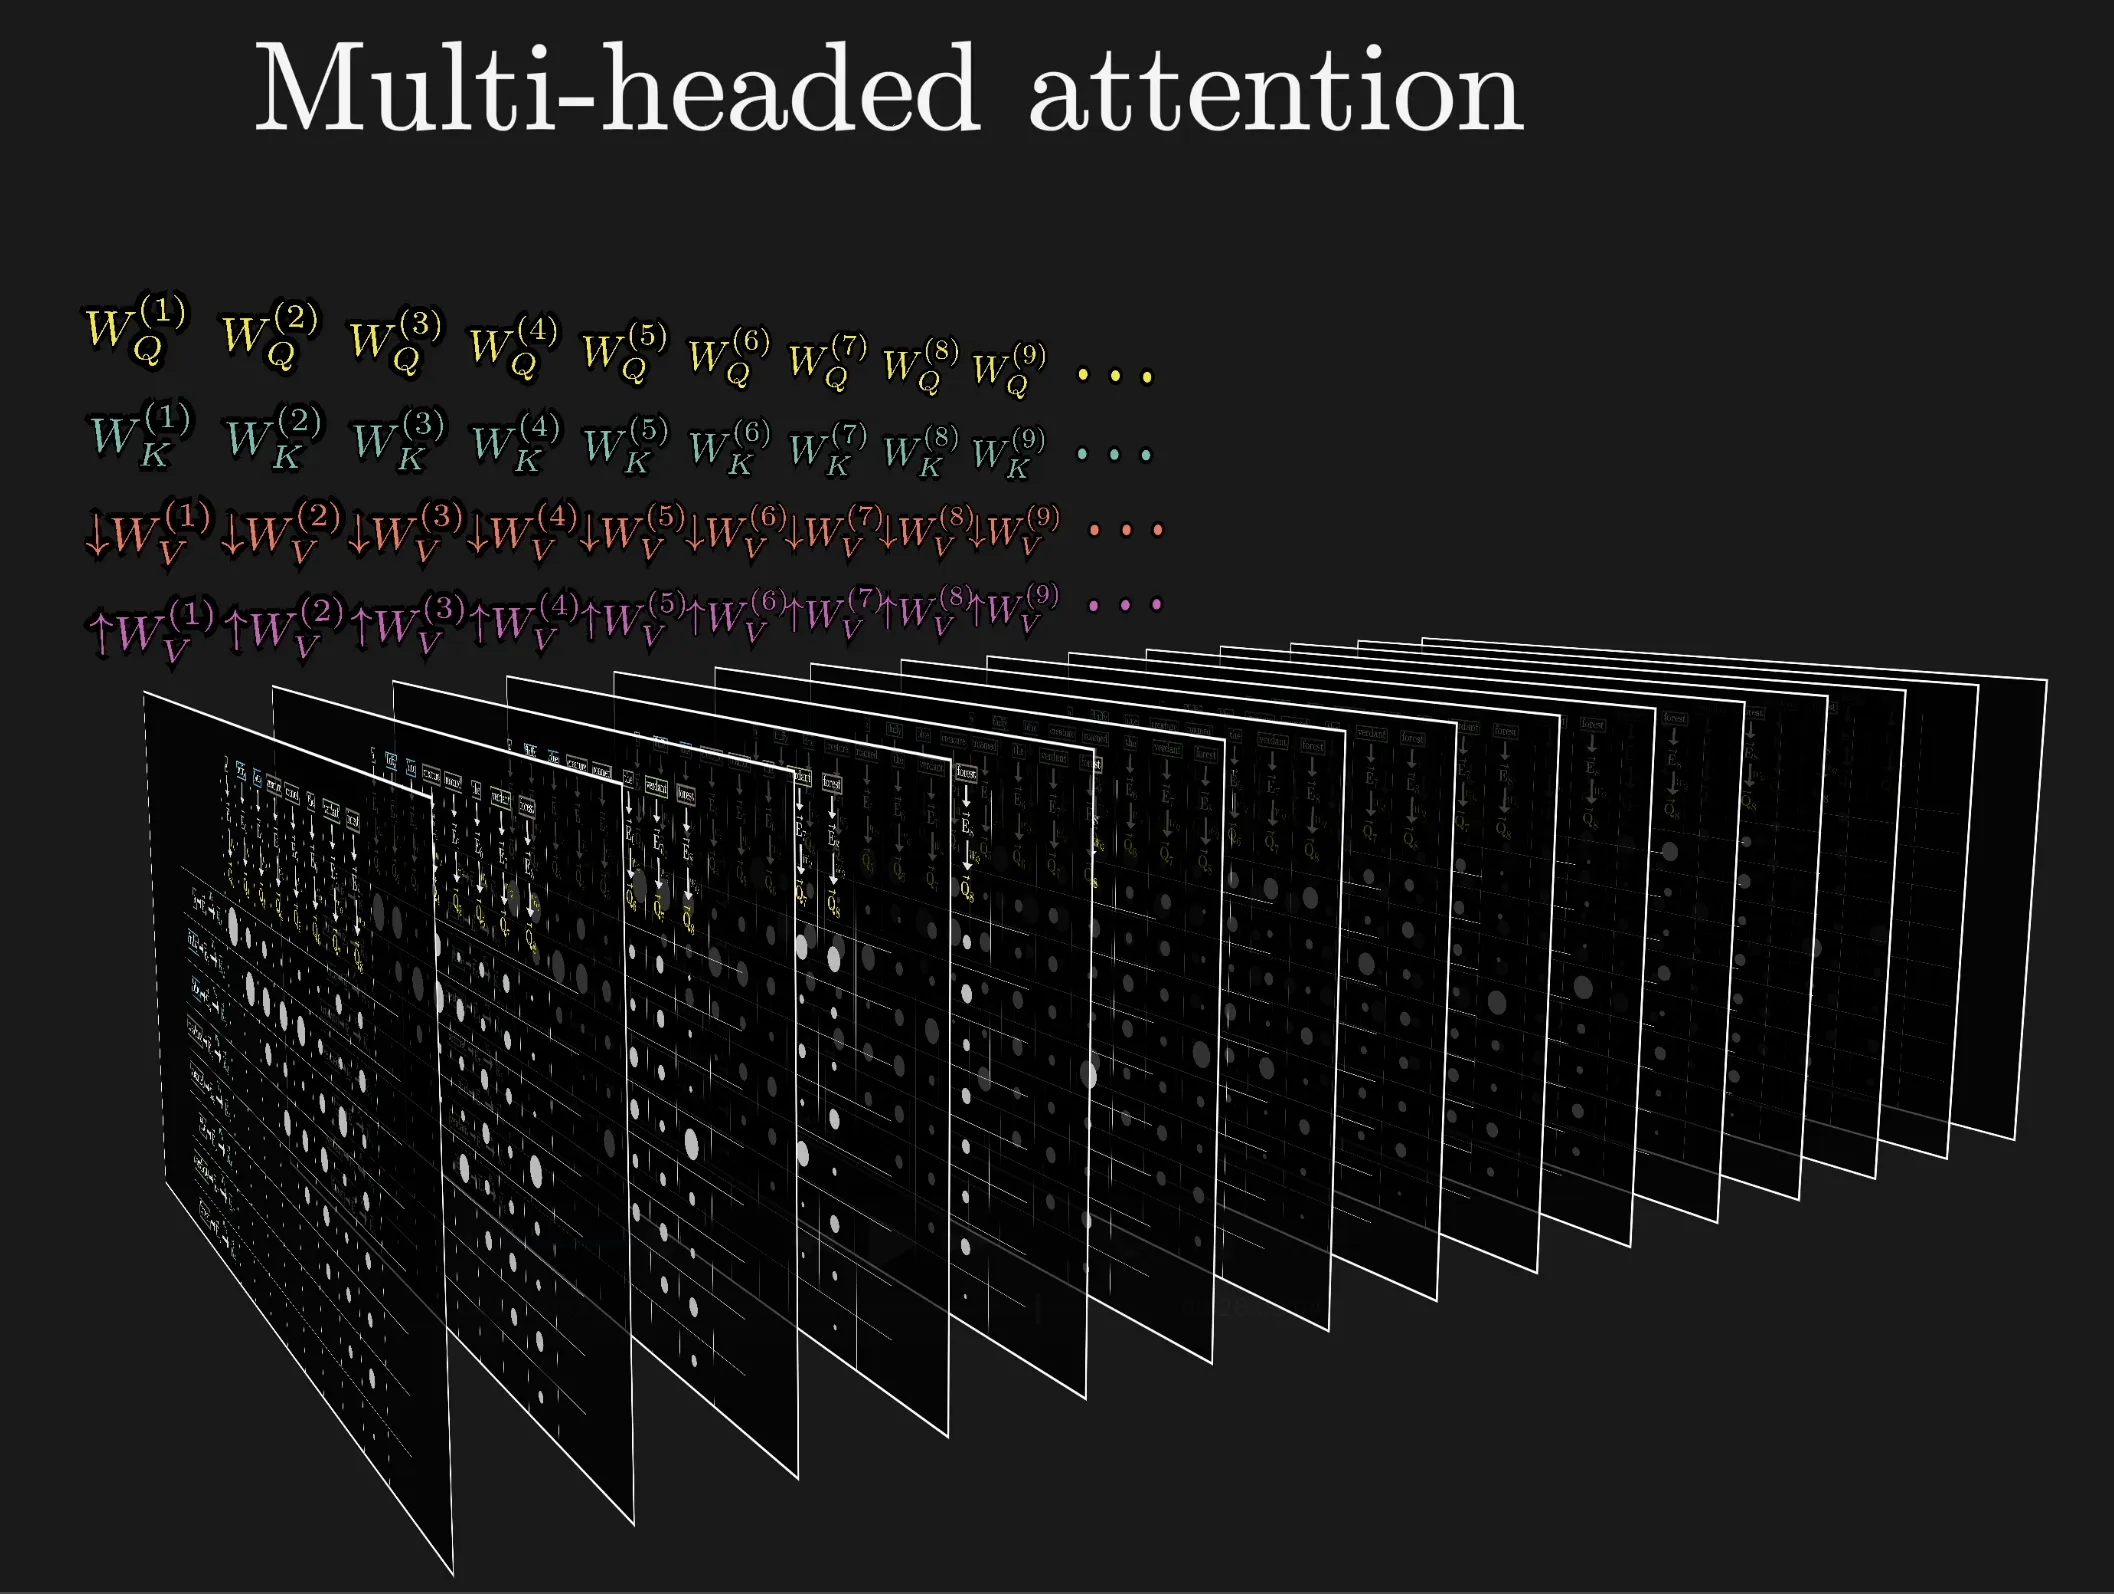

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        参数：
        - d_model: 模型的特征维度（如512）
        - num_heads: 注意力头的数量（如8）

        注意：d_model 必须能整除 num_heads，否则每个头的维度无法均分
        """
        super().__init__()

        assert d_model % num_heads == 0  # 保证每个头的维度是整数

        self.d_k = d_model // num_heads  # 每个头的 key/query/value 的维度
        self.num_heads = num_heads       # 多头数量

        # 为 Q、K、V 分别定义线性映射层（将 d_model -> d_model）
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # 输出线性映射（将多头结果拼接后再投影回 d_model）
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        参数：
        - q, k, v: 查询、键、值张量，形状通常是 (batch_size, seq_len, d_model)
        - mask: 注意力掩码，用于屏蔽某些位置（如padding或未来信息）

        返回：
        - output: 多头注意力结果，形状为 (batch_size, seq_len, d_model)
        - attn: 所有头的注意力权重 (batch_size, num_heads, seq_len, seq_len)
        """

        batch_size = q.size(0)  # 获取batch大小

        # Step 1：Q, K, V 线性变换 + 分头
        # 原始形状：(batch_size, seq_len, d_model)
        # 变成：(batch_size, seq_len, num_heads, d_k) 再转置为：
        #       (batch_size, num_heads, seq_len, d_k)
        q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Step 2：对每个头计算 Scaled Dot-Product Attention
        attn_output, attn = scaled_dot_product_attention(q, k, v, mask)
        # attn_output: (batch_size, num_heads, seq_len, d_k)

        # Step 3：合并多头结果
        # 首先将多头的输出转置回来：(batch_size, seq_len, num_heads, d_k)
        # 然后拼接在一起 -> (batch_size, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.num_heads * self.d_k
        )

        # Step 4：输出线性层映射到 d_model
        output = self.w_o(attn_output)

        return output, attn


## 4. 前馈网络（Feed Forward Network）
+ **输入**：形状`(batch, seq, d_model)` 的张量。
+ **处理**：
    - 通过两层线性层，中间有 ReLU 激活和 dropout。
    - 第一个线性层将维度扩展到`d_ff`，增强表达能力。
    - 第二个线性层将维度降回`d_model` ，保持和输入维度一致，方便残差连接。
+ **输出**：形状`(batch, seq, d_model)` 的张量。
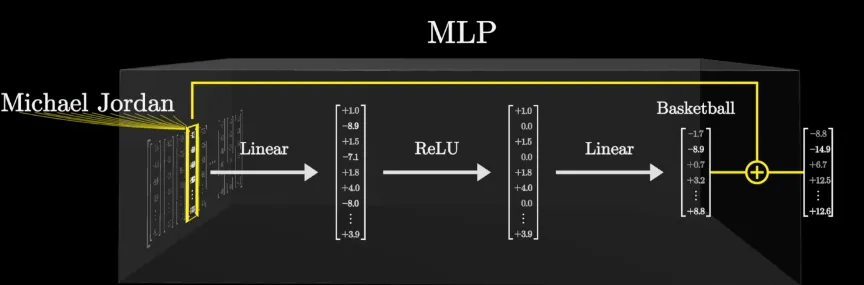

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        """
        前馈全连接网络（Position-wise Feed-Forward Network）

        参数：
        - d_model: 输入和输出的维度（与Transformer中保持一致）
        - d_ff: 隐藏层的维度，通常远大于 d_model（例如2048）
        - dropout: Dropout 比例，用于防止过拟合
        """
        super().__init__()
        # 第一个线性层：把 d_model 映射到更高维（d_ff）
        self.linear1 = nn.Linear(d_model, d_ff)
        # Dropout 层
        self.dropout = nn.Dropout(dropout)
        # 第二个线性层：再将 d_ff 映射回 d_model
        self.linear2 = nn.Linear(d_ff, d_model)
        # 激活函数 ReLU，非线性变换
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        输入：
        - x: 输入张量，形状为 (batch_size, seq_len, d_model)

        输出：
        - 与输入形状相同的张量 (batch_size, seq_len, d_model)
        """
        # 执行顺序：线性 → ReLU → Dropout → 线性
        return self.linear2(self.dropout(self.relu(self.linear1(x))))


## 5. 编码器层（Encoder Layer）
+ **输入**：形状`(batch, seq, d_model` 的张量和可选掩码。
+ **处理**：
    - 自注意力模块：输入与自己进行多头自注意力计算，得到注意力输出。
    - 残差连接与 LayerNorm：将自注意力输出与输入相加，再做归一化。
    - 前馈网络模块：对归一化结果进行前馈网络计算。
    - 残差连接与 LayerNorm：将前馈网络输出与前面结果相加，再做归一化。
+ **输出**：编码器层的输出，形状`(batch, seq, d_model)` 。

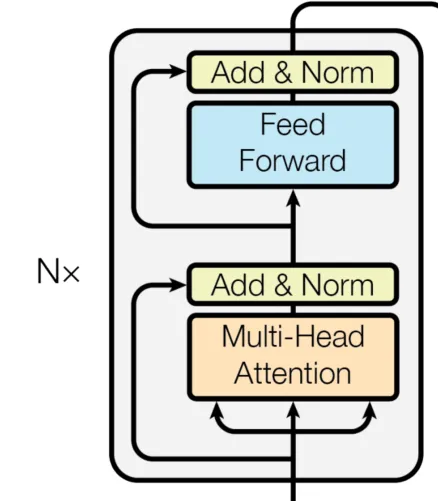

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        Transformer 编码器层（Encoder Layer）

        参数：
        - d_model: 模型维度（输入/输出维度）
        - num_heads: 多头注意力的头数
        - d_ff: 前馈网络的隐藏层维度
        - dropout: dropout概率
        """
        super().__init__()
        # 多头自注意力机制
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # 前馈全连接网络
        self.ffn = FeedForward(d_model, d_ff, dropout)

        # 两个 LayerNorm 层：用于残差连接后的归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # 两个 Dropout 层：用于正则化
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        输入：
        - x: 输入张量，形状为 (batch_size, seq_len, d_model)
        - mask: 掩码张量（用于防止注意力关注填充位置）

        输出：
        - 与输入形状相同的张量 (batch_size, seq_len, d_model)
        """
        # ===== 第一步：多头自注意力 =====
        # Q=K=V=x，自注意力
        attn_out, _ = self.self_attn(x, x, x, mask)
        # 残差连接 + dropout + LayerNorm
        x = self.norm1(x + self.dropout1(attn_out))

        # ===== 第二步：前馈网络 =====
        ffn_out = self.ffn(x)
        # 残差连接 + dropout + LayerNorm
        x = self.norm2(x + self.dropout2(ffn_out))

        return x


## 6. 编码器（Encoder）
+ **输入**：源序列词索引张量`(batch, src_seq, d_model)`，可选掩码。
+ **处理**：
    - 词嵌入：将词索引映射成词向量。
    - 位置编码：给词嵌入添加位置编码。
    - dropout处理。
    - 依次通过多层编码器层，逐步抽取和融合序列特征。
+ **输出**：编码器最后一层输出，形状`(batch, src_seq, d_model)`。

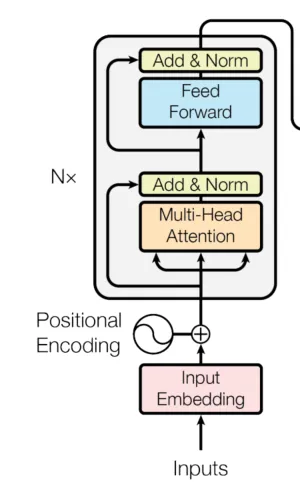

In [8]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff=2048, max_len=5000, dropout=0.1):
        """
        Transformer 编码器整体模块

        参数：
        - vocab_size: 词表大小
        - d_model: 模型维度（词嵌入和输出维度）
        - num_layers: 编码器层数
        - num_heads: 多头注意力头数
        - d_ff: 前馈网络隐藏层维度
        - max_len: 序列最大长度（用于位置编码）
        - dropout: dropout比例
        """
        super().__init__()
        # 词嵌入层，将词ID映射成d_model维的向量
        self.embedding = nn.Embedding(vocab_size, d_model)
        # 位置编码层，给序列中每个位置注入位置信息
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        # 多个编码器层堆叠，组成深层编码器
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        # 输入dropout，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask=None):
        """
        参数：
        - src: 输入序列，形状 (batch_size, seq_len)，元素是词索引
        - mask: 掩码张量，形状适配于注意力模块

        返回：
        - 编码器输出，形状 (batch_size, seq_len, d_model)
        """
        # 词嵌入后乘以 sqrt(d_model) 缩放因子，提高稳定性
        x = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        # 加上位置编码
        x = self.pos_encoding(x)
        # 输入dropout
        x = self.dropout(x)
        # 依次通过每一层编码器层
        for layer in self.layers:
            x = layer(x, mask)
        return x


## 7. 解码器层（Decoder Layer）
+ **输入**：目标序列输入张量，编码器输出，源和目标掩码。
+ **处理**：
    - Masked 自注意力：对目标序列自身进行多头注意力，带因果掩码，防止看到未来词。
    - 残差连接与 LayerNorm。
    - 编码器-解码器注意力：目标作为查询，编码器输出作为键值，融合编码上下文信息。
    - 残差连接与 LayerNorm。
    - 前馈网络及残差连接与 LayerNorm。
+ **输出**：解码器层输出，形状`(batch, tgt_seq, d_model)`。

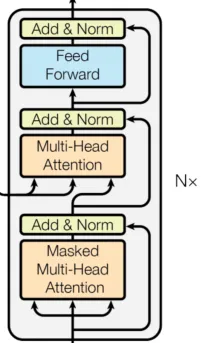

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        Transformer 解码器层（Decoder Layer）

        参数：
        - d_model: 模型维度（输入/输出维度）
        - num_heads: 多头注意力头数
        - d_ff: 前馈网络隐藏层维度
        - dropout: dropout比例
        """
        super().__init__()
        # Masked 多头自注意力（防止模型看到未来信息）
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # 编码器-解码器多头注意力，用于关注编码器输出
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        # 前馈网络
        self.ffn = FeedForward(d_model, d_ff, dropout)

        # 三个 LayerNorm 层，分别用于三处残差连接的归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        # 三个 dropout 层
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        """
        输入：
        - x: 当前解码器输入 (batch_size, tgt_seq_len, d_model)
        - enc_out: 编码器输出 (batch_size, src_seq_len, d_model)
        - src_mask: 编码器输入掩码，用于防止关注填充等无效位置
        - tgt_mask: 解码器输入掩码，通常是因果掩码，防止预测时看到未来词

        输出：
        - 解码器层输出 (batch_size, tgt_seq_len, d_model)
        """
        # ===== 第一步：masked 多头自注意力 =====
        # 只允许关注当前位置及之前位置，防止信息泄露
        attn1, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn1))  # 残差 + LayerNorm

        # ===== 第二步：编码器-解码器多头注意力 =====
        # 解码器当前状态作为 query，编码器输出作为 key 和 value
        attn2, _ = self.cross_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout2(attn2))  # 残差 + LayerNorm

        # ===== 第三步：前馈网络 =====
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_out))  # 残差 + LayerNorm

        return x


## 8. 解码器（Decoder）
+ **输入**：目标序列词索引张量，编码器输出，源和目标掩码。
+ **处理**：
    - 词嵌入、位置编码、dropout。
    - 多层解码器层堆叠，逐层融合目标上下文和编码器信息。
+ **输出**：解码器最终输出，形状`(batch, tgt_seq, d_model)`。

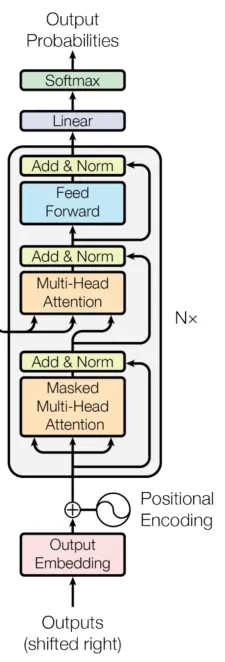

In [10]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff=2048, max_len=5000, dropout=0.1):
        """
        Transformer 解码器整体模块

        参数：
        - vocab_size: 目标词表大小
        - d_model: 模型维度（词嵌入和输出维度）
        - num_layers: 解码器层数
        - num_heads: 多头注意力头数
        - d_ff: 前馈网络隐藏层维度
        - max_len: 序列最大长度（用于位置编码）
        - dropout: dropout比例
        """
        super().__init__()
        # 词嵌入层，将词ID映射成 d_model 维向量
        self.embedding = nn.Embedding(vocab_size, d_model)
        # 位置编码层，为序列中的每个位置添加位置信息
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        # 堆叠多个解码器层
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        # dropout 层，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        """
        参数：
        - tgt: 解码器输入序列，形状 (batch_size, tgt_seq_len)，元素为目标词索引
        - enc_out: 编码器输出，形状 (batch_size, src_seq_len, d_model)
        - src_mask: 编码器输入掩码（可选）
        - tgt_mask: 解码器输入掩码，通常为因果掩码，防止看到未来词（可选）

        返回：
        - 解码器输出，形状 (batch_size, tgt_seq_len, d_model)
        """
        # 词嵌入后乘以 sqrt(d_model) 缩放因子，提高数值稳定性
        x = self.embedding(tgt) * math.sqrt(self.embedding.embedding_dim)
        # 添加位置编码
        x = self.pos_encoding(x)
        # 输入 dropout
        x = self.dropout(x)
        # 依次通过各解码器层，融合编码器上下文信息
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
        return x


## 9. Transformer 整体模型
+ **输入**：源序列词索引`src`、目标序列词索引`tgt`。
+ **处理**：
    - 生成源序列掩码（padding mask）。
    - 生成目标序列掩码（padding + 因果mask）。
    - 编码器处理源序列，得到上下文编码。
    - 解码器处理目标序列并利用编码器上下文，得到隐状态。
    - 线性层映射解码器输出到词表维度，用于后续softmax预测。
+ **输出**：目标词表概率分布 logits，形状`(batch, tgt_seq, tgt_vocab_size)`。

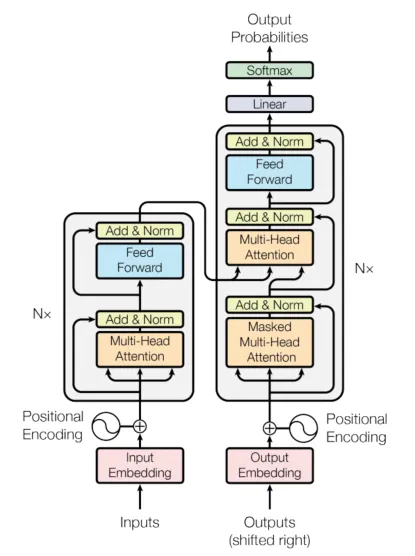

In [11]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, max_len=5000, dropout=0.1):
        """
        Transformer整体模型

        参数：
        - src_vocab_size: 源语言词表大小
        - tgt_vocab_size: 目标语言词表大小
        - d_model: 模型维度（词嵌入及隐藏层维度）
        - num_layers: 编码器和解码器的层数
        - num_heads: 多头注意力头数
        - d_ff: 前馈网络隐藏层维度
        - max_len: 最大序列长度（位置编码使用）
        - dropout: dropout比例
        """
        super().__init__()
        # 编码器模块
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout)
        # 解码器模块
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout)
        # 最后的线性层，将模型输出映射到目标词表大小，供softmax分类
        self.linear_out = nn.Linear(d_model, tgt_vocab_size)

    def make_src_mask(self, src):
        """
        生成源序列掩码（padding mask）

        输入：
        - src: (batch_size, src_len) 源序列词ID

        输出：
        - mask: (batch_size, 1, 1, src_len) bool张量
          True表示对应位置是有效词，False表示padding部分需mask掉
        """
        mask = (src != 0).unsqueeze(1).unsqueeze(2)  # 扩展维度用于广播
        return mask

    def make_tgt_mask(self, tgt):
        """
        生成目标序列掩码，结合padding mask和因果mask

        输入：
        - tgt: (batch_size, tgt_len) 目标序列词ID

        输出：
        - tgt_mask: (batch_size, 1, tgt_len, tgt_len) bool张量
          True表示对应位置可见，False表示需屏蔽（padding或未来词）
        """
        batch_size, tgt_len = tgt.size()
        # padding mask，True为有效词
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        # 因果mask（下三角矩阵），防止看到未来词
        nopeak_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        # 同时满足padding有效且因果mask
        tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask

    def forward(self, src, tgt):
        """
        Transformer前向传播

        输入：
        - src: (batch_size, src_len) 源序列词ID
        - tgt: (batch_size, tgt_len) 目标序列词ID

        返回：
        - output: (batch_size, tgt_len, tgt_vocab_size) 解码器输出对应词表的logits
        """
        # 构造掩码
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        # 编码器前向
        enc_out = self.encoder(src, src_mask)
        # 解码器前向，利用编码器输出和掩码
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        # 线性映射到词表维度，供后续softmax计算概率
        output = self.linear_out(dec_out)
        return output


## 10.模型测试
这样所有代码就完成了，下面我们可以编写代码进行测试。

In [12]:
# 源语言词汇大小 src_vocab_size = 1000

# 目标语言词汇大小 tgt_vocab_size = 1000

# 序列长度为 src_seq_len = 10，tgt_seq_len = 9

# batch size = 2


import torch

# 设定参数
src_vocab_size = 1000
tgt_vocab_size = 1000
d_model = 512
num_layers = 2
num_heads = 8
batch_size = 2
src_seq_len = 10
tgt_seq_len = 9

# 实例化模型
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads)

# 生成随机输入（整数token，范围在[1, vocab_size)）
# 注意0一般作为padding token，不填充这里直接用非0随机数
src_input = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
tgt_input = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))

# 模型推理
output = model(src_input, tgt_input)

print("输出维度:", output.shape)
# 输出维度应为 (batch_size, tgt_seq_len, tgt_vocab_size)


输出维度: torch.Size([2, 9, 1000])
